In [59]:
from typing import Any, List, Tuple

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import make_scorer
from pipe.baseline import Baseline

In [60]:
pd.set_option("display.max_rows", None)  # 行数の上限を設定しない
pd.set_option("display.max_columns", None)  # 列数の上限を設定しない
pd.set_option("display.max_colwidth", None)  # 列の幅を制限しない

In [61]:
df_train = pd.read_csv("../data/train.csv")

df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [62]:
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [63]:
print(
    df_train[
        [
            "OverallQual",
            "GrLivArea",
            "GarageCars",
            "TotalBsmtSF",
            "FullBath",
            "YearBuilt",
        ]
    ]
    .isnull()
    .sum()
)

OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
dtype: int64


In [64]:
columns_to_non_numeric = [
    "MSSubClass",
    "OverallQual",
    "OverallCond",
    "BsmtFullBath",
    "HalfBath",
    "BsmtHalfBath",
    "FullBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "MoSold",
    "YrSold",
]

df_numeric_features = df_train.select_dtypes(include=[np.number])
df_categorical_features = df_train.select_dtypes(exclude=[np.number])

df_categorical_features = pd.concat([df_categorical_features, df_numeric_features[columns_to_non_numeric]], axis=1)
df_numeric_features.drop(columns=columns_to_non_numeric, inplace=True)

df_numeric_features.isnull().sum()

Id                 0
LotFrontage      259
LotArea            0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageYrBlt       81
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
SalePrice          0
dtype: int64

In [65]:
num_features = len(df_numeric_features)

num_features

1460

## y軸住宅価格、横軸カテゴリ変数として散布図をプロット

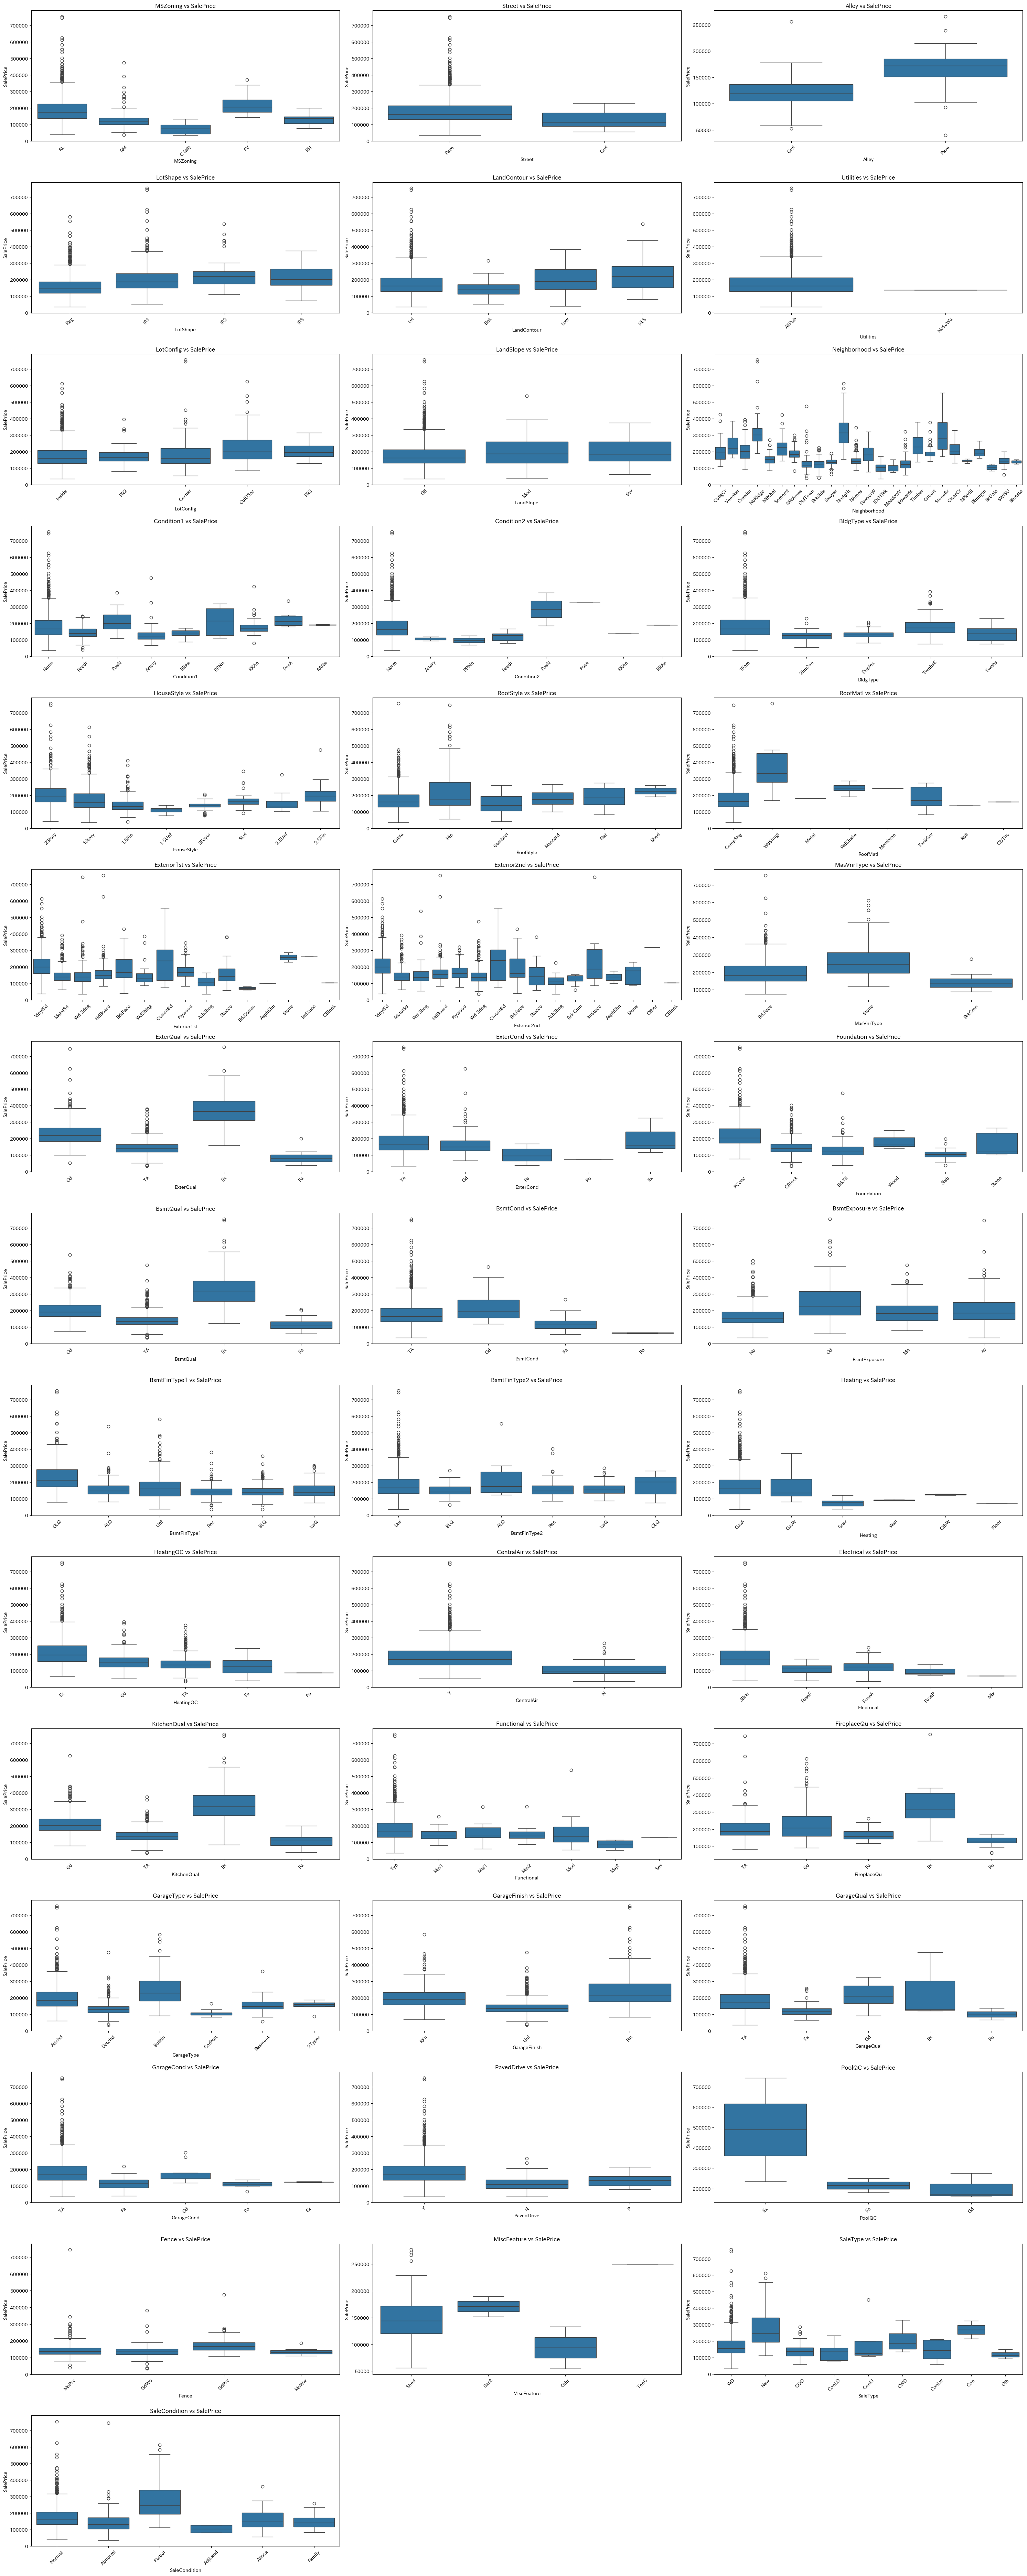

In [66]:
# 数値データのカラムのみ選択
categorical_features = df_train.select_dtypes(exclude=["int64", "float64"]).columns

# 目的変数（SalePrice）を除く
features = [feature for feature in categorical_features if feature != "SalePrice"]

# グラフの作成
num_features = len(features)
num_cols = 3  # 列数
num_rows = (num_features + num_cols - 1) // num_cols  # 必要な行数を計算

plt.figure(figsize=(10 * num_cols, 5 * num_rows))  # グラフのサイズを調整

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x=feature, y="SalePrice", data=df_train)
    plt.xlabel(feature)
    plt.ylabel("SalePrice")
    plt.xticks(rotation=45)
    plt.title(f"{feature} vs SalePrice")

plt.tight_layout()
plt.show()

## y軸住宅価格、横軸数値変数として散布図をプロット

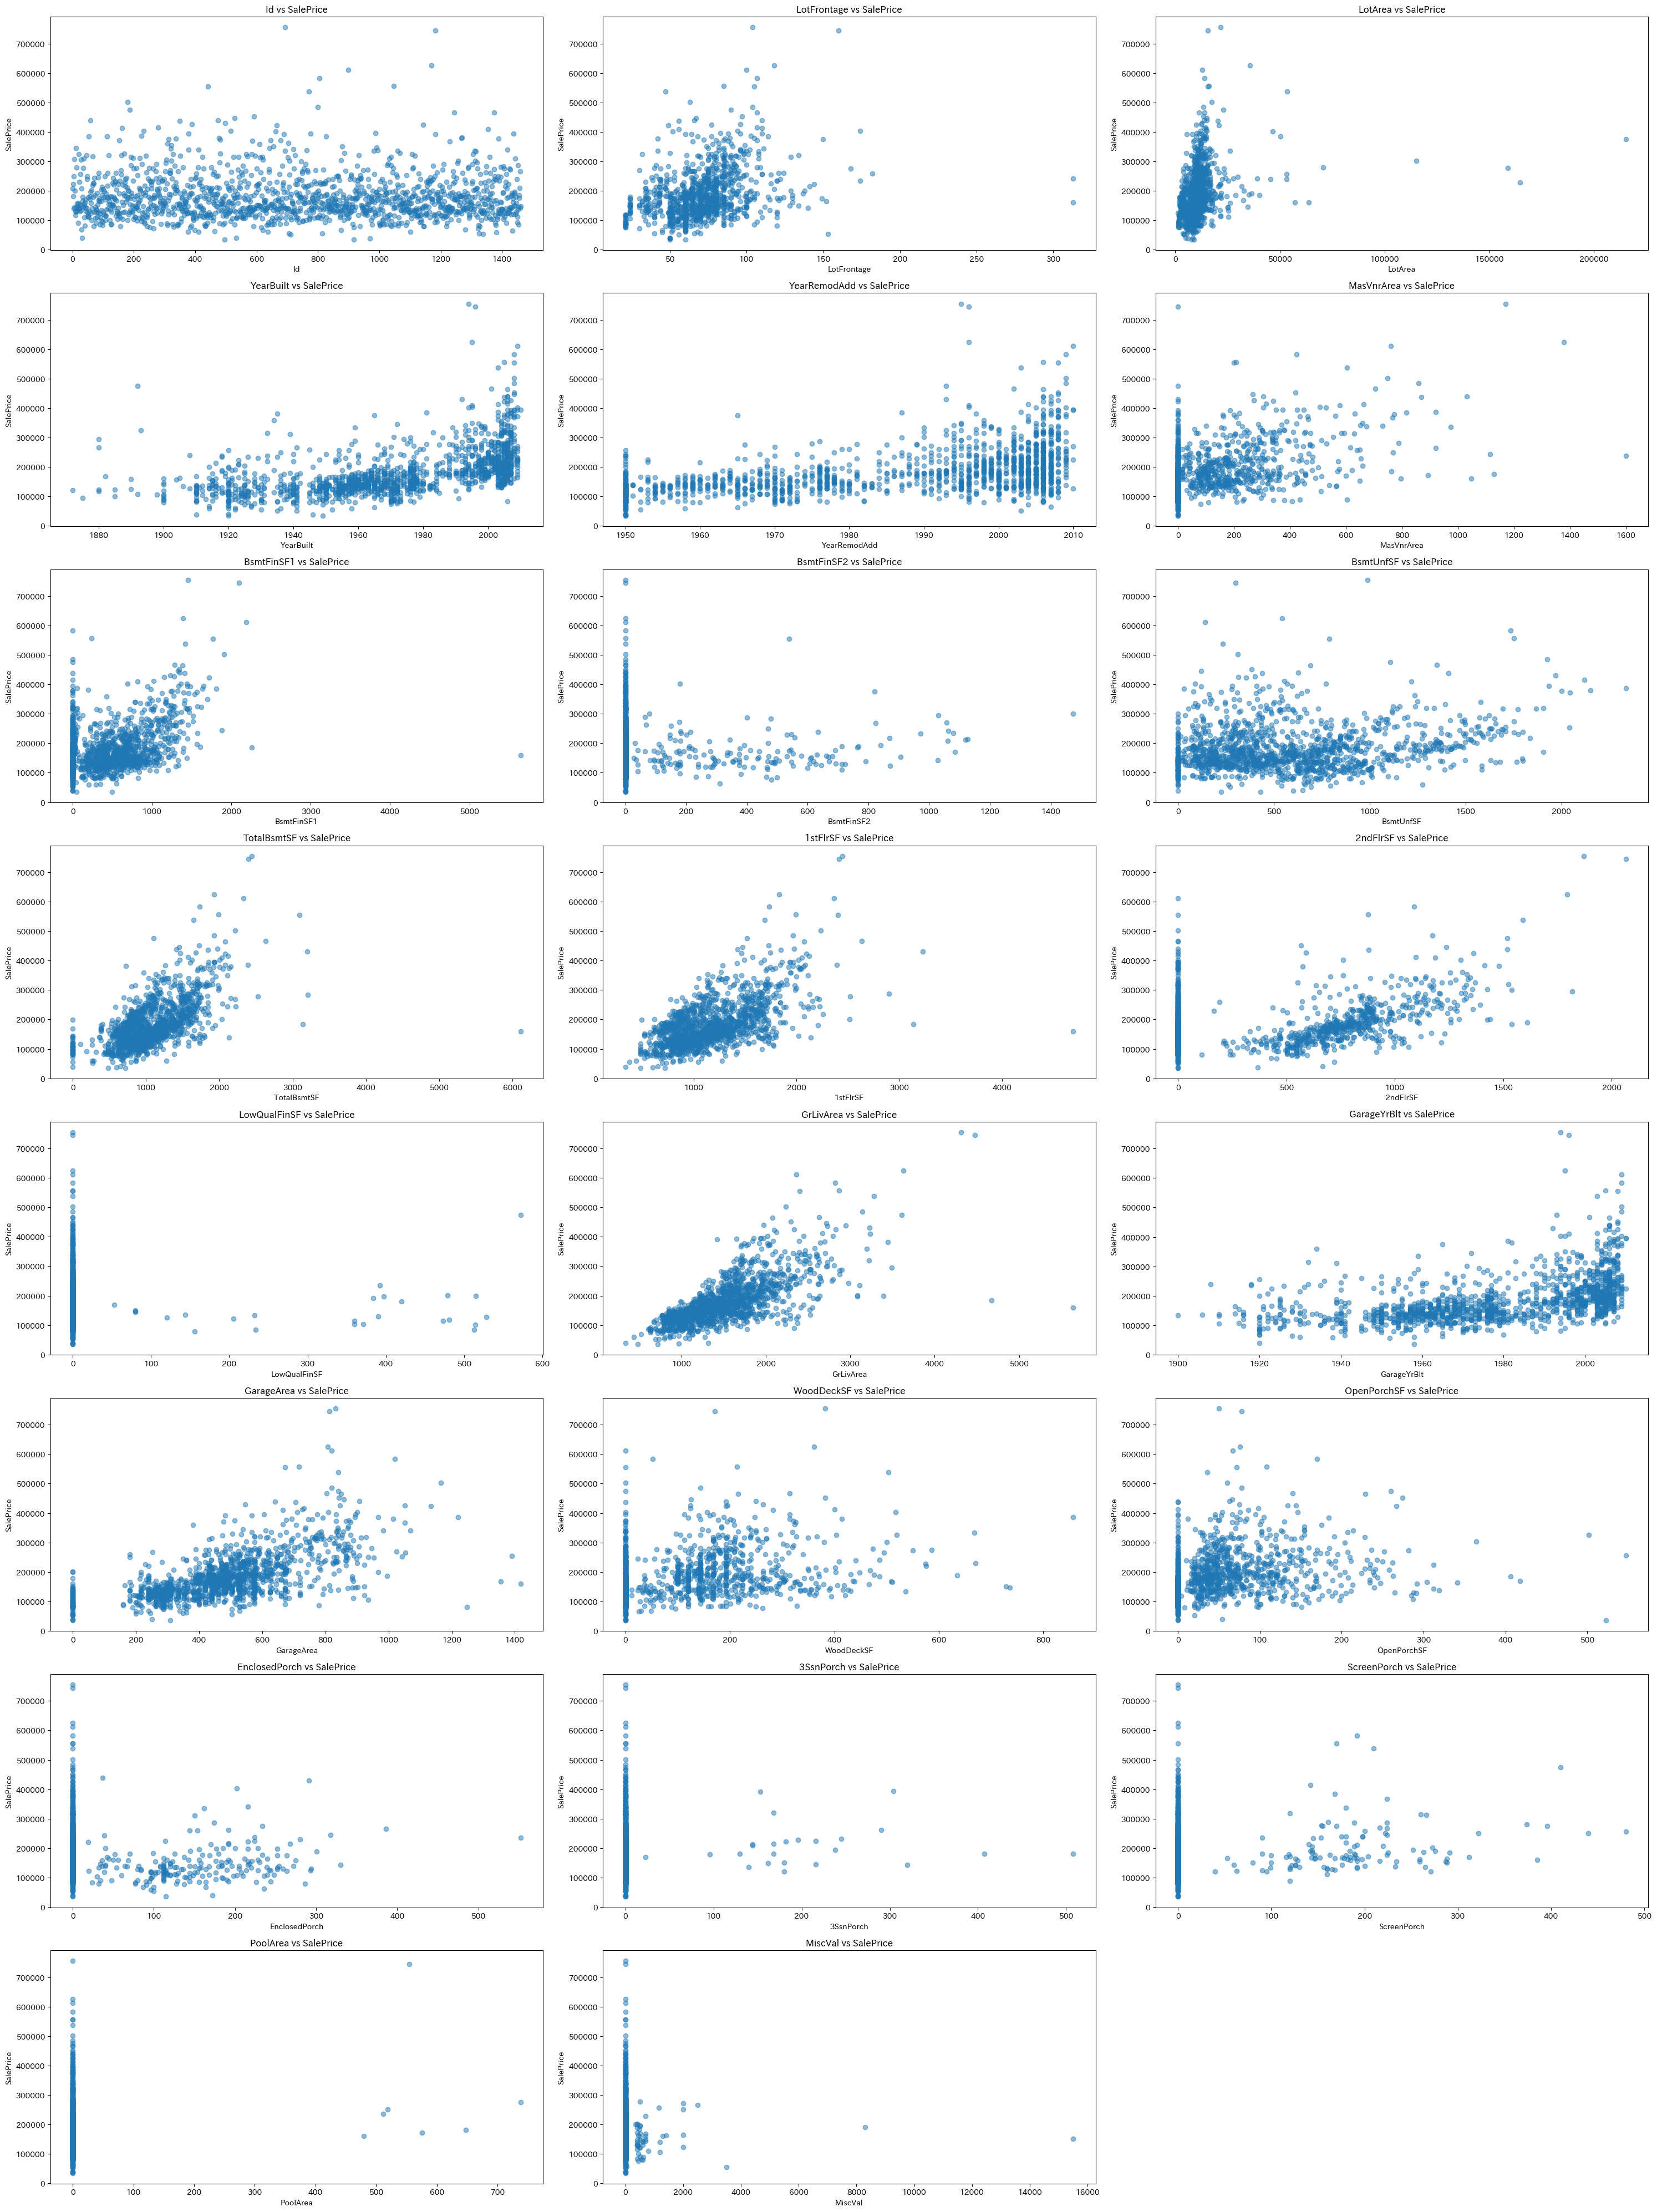

In [67]:



# 目的変数（SalePrice）を除く
features = [feature for feature in df_numeric_features if feature != "SalePrice"]

# グラフの作成
num_features = len(features)
num_cols = 3  # 列数
num_rows = (num_features + num_cols - 1) // num_cols  # 必要な行数を計算

plt.figure(figsize=(10 * num_cols, 5 * num_rows))  # グラフのサイズを調整

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(df_train[feature], df_train["SalePrice"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("SalePrice")
    plt.title(f"{feature} vs SalePrice")

plt.tight_layout()
plt.show()

## ペアプロット

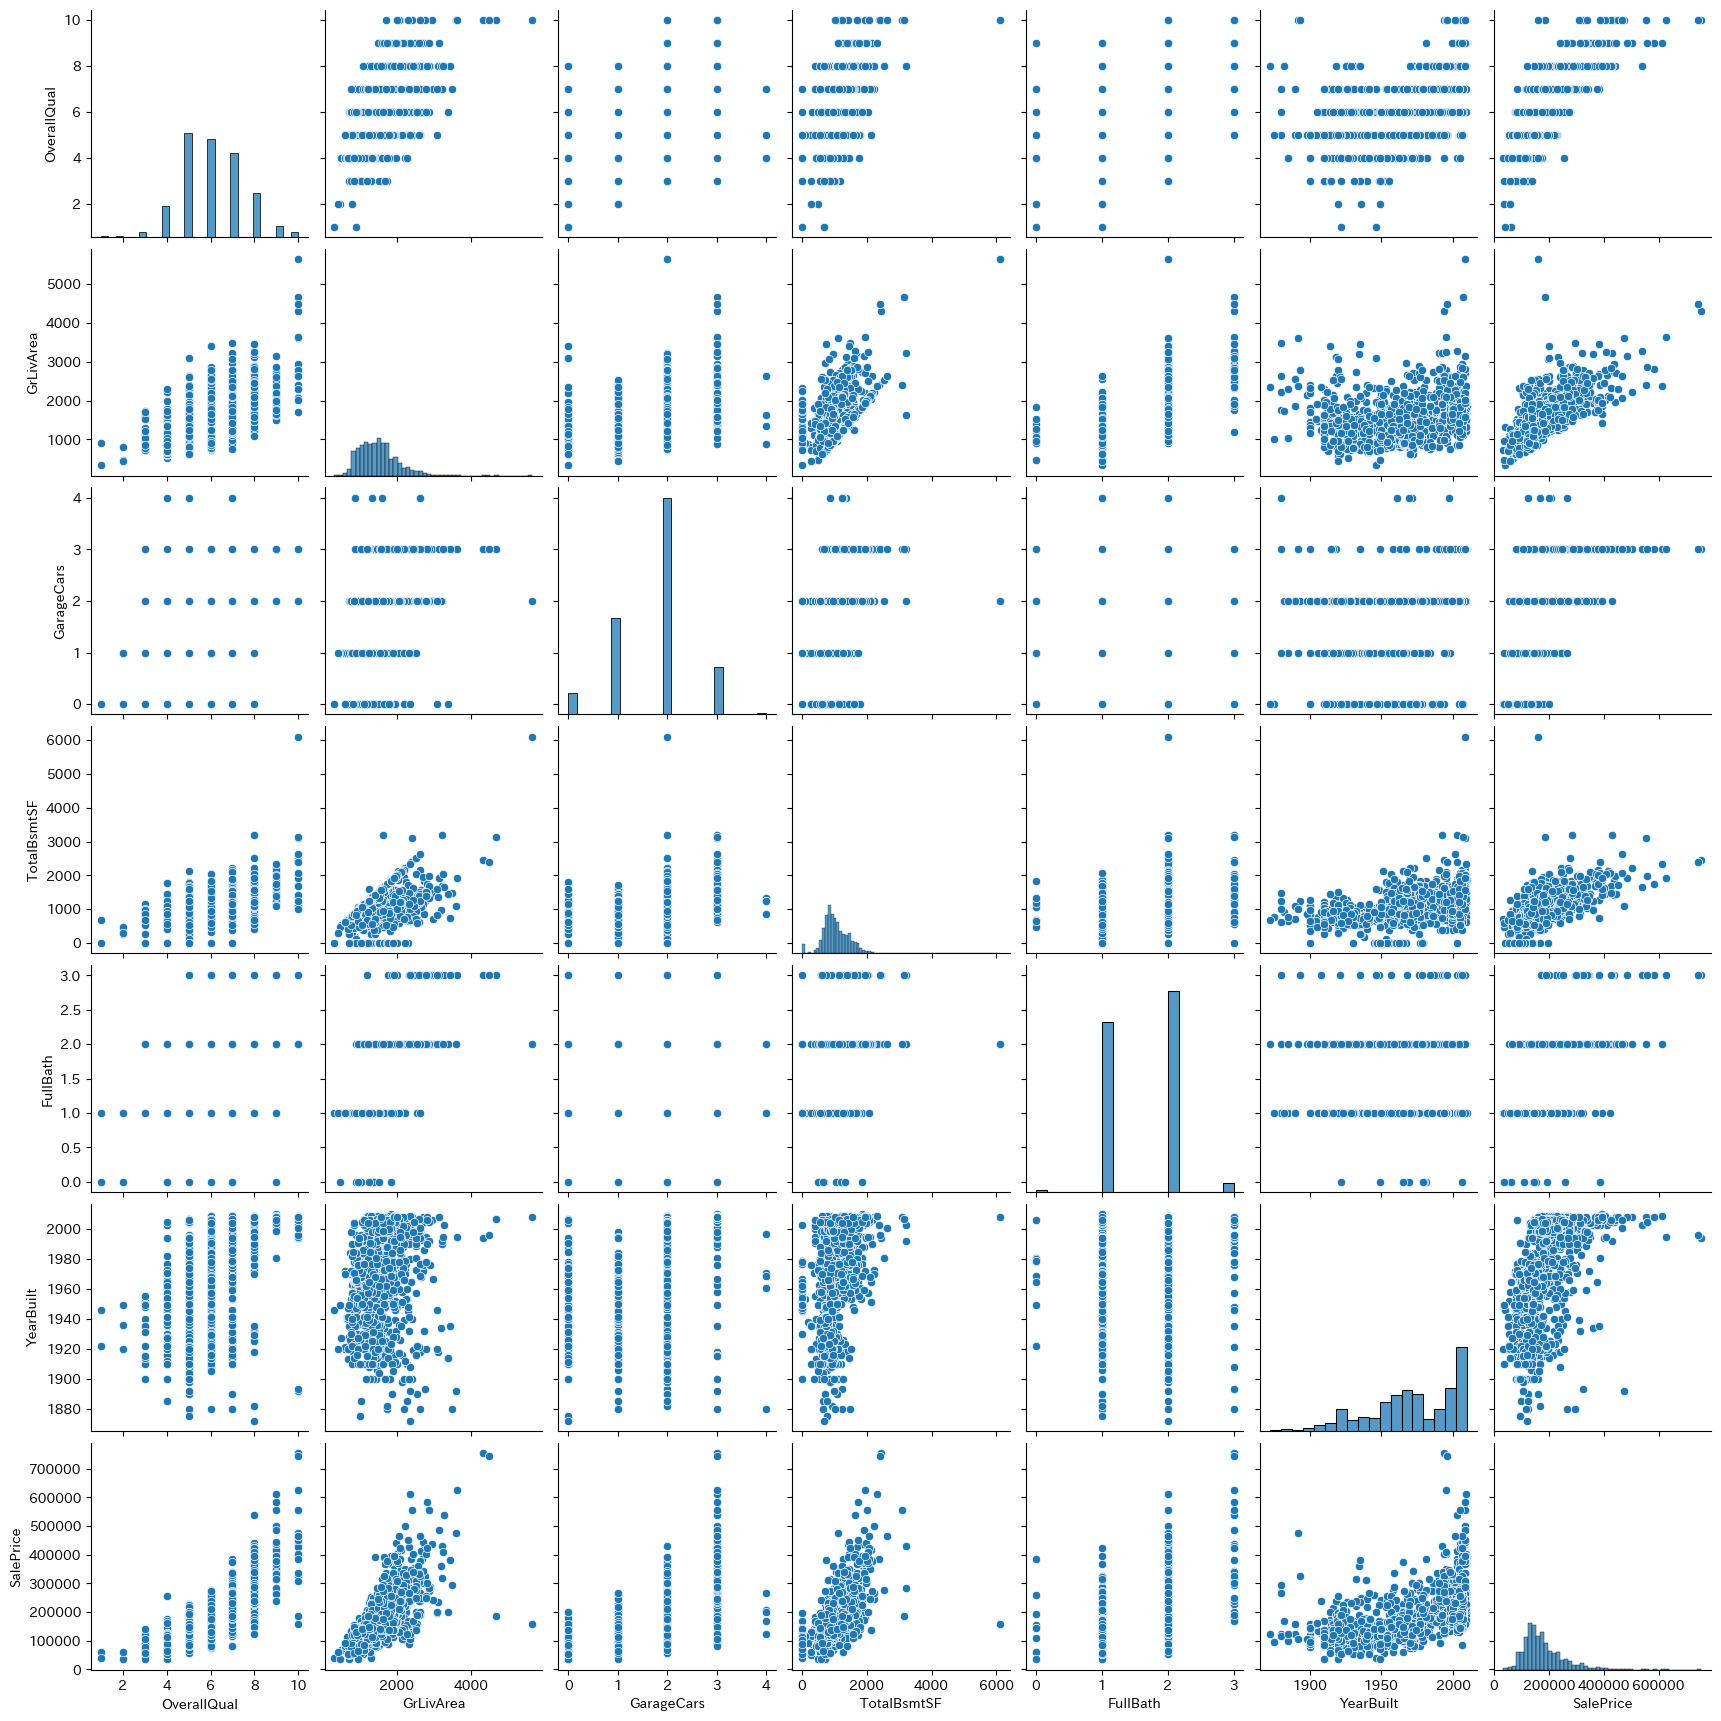

In [68]:
selected_features = [
    "OverallQual",
    "GrLivArea",
    "GarageCars",
    "TotalBsmtSF",
    "FullBath",
    "YearBuilt",
    "SalePrice",
]
sns.pairplot(df_train[selected_features])
plt.show()

## 相関行列のヒートマップをプロット

<Axes: >

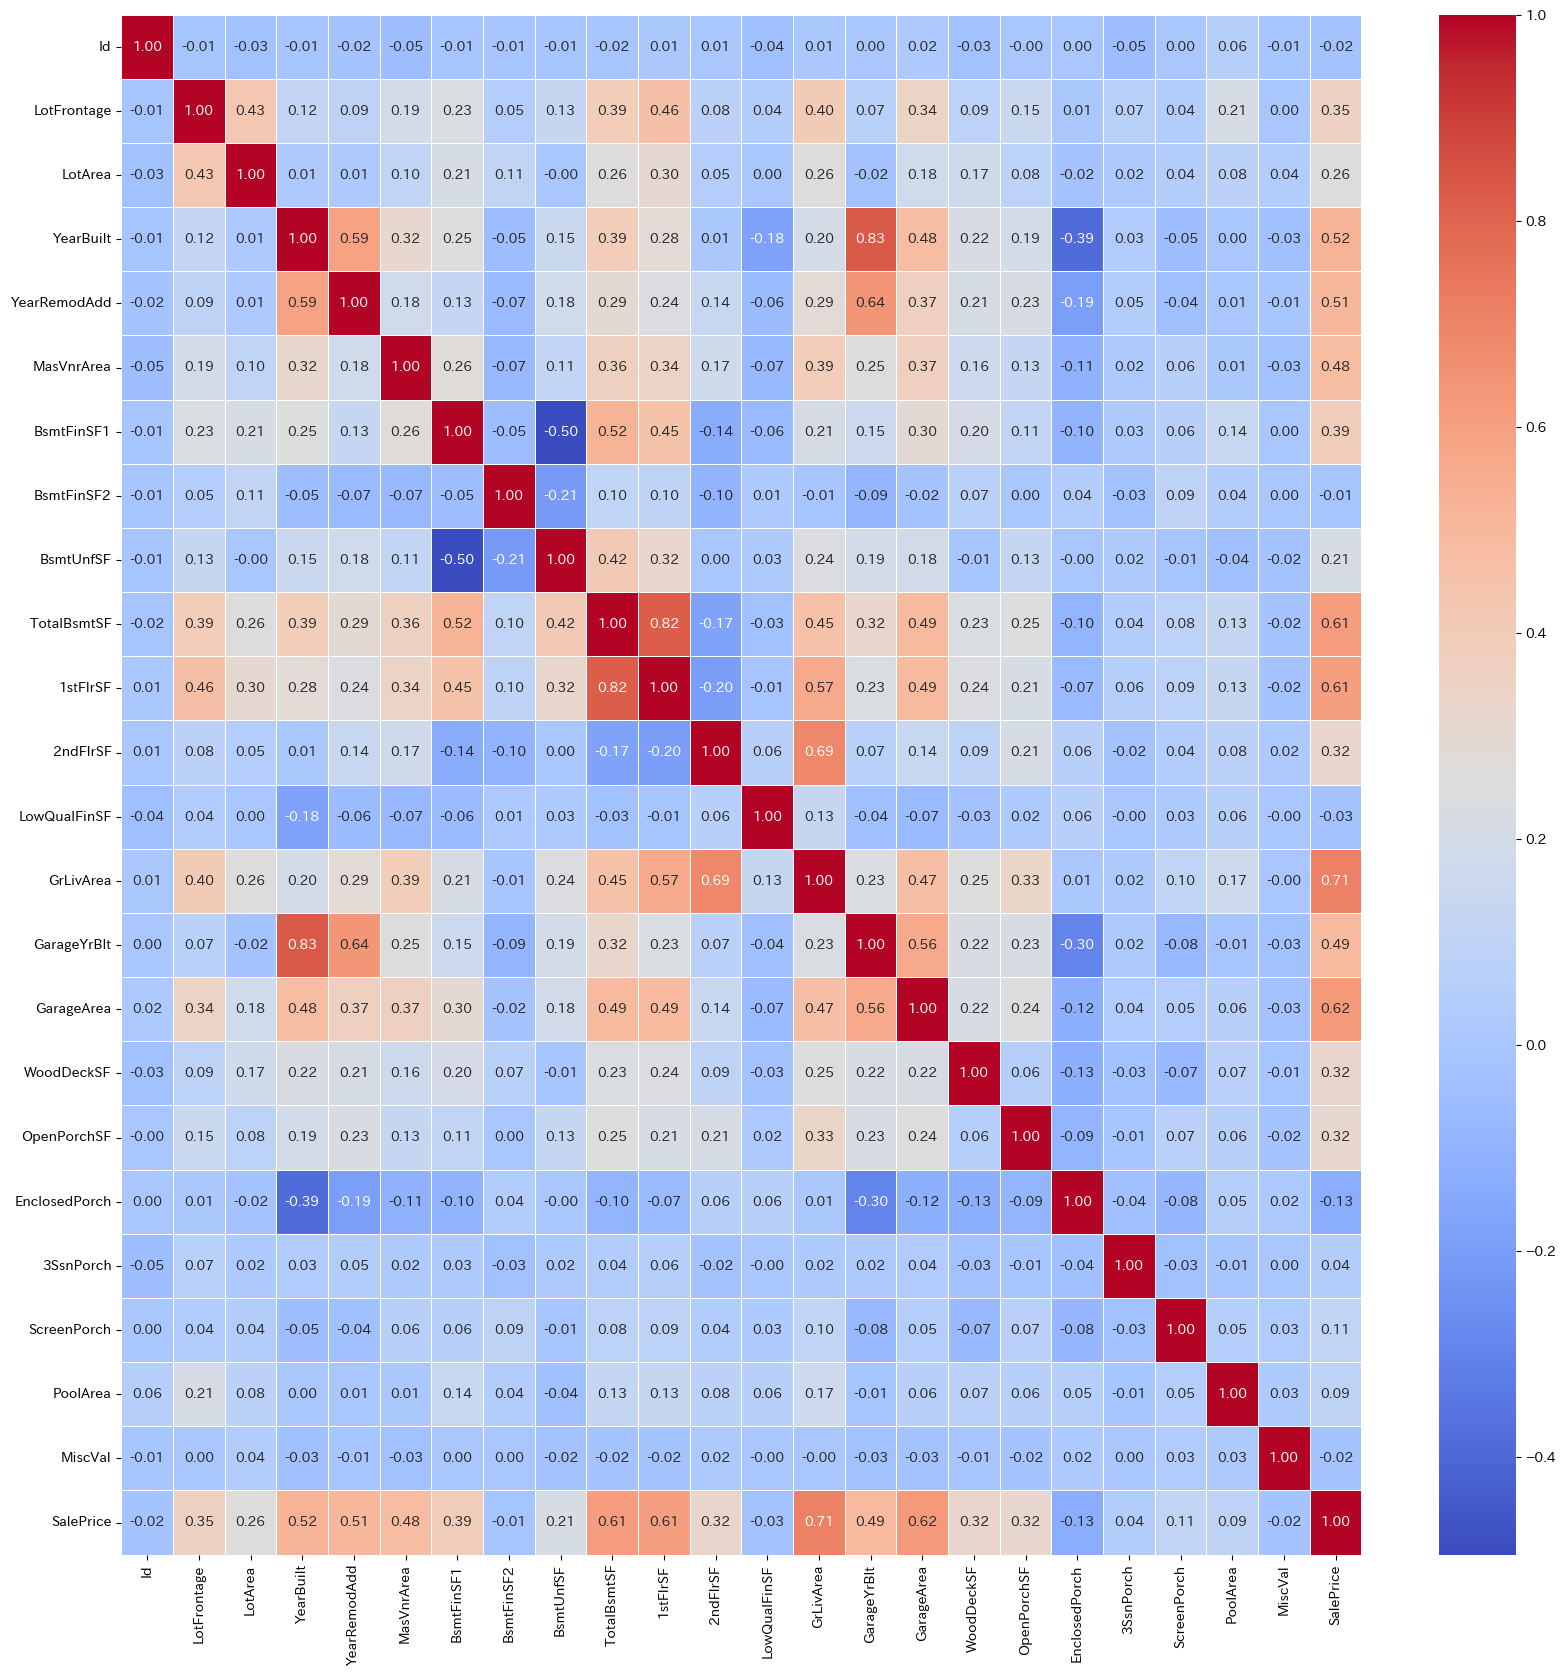

In [69]:
corr_err = df_numeric_features.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_err,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
)

### ヒストグラムのプロット

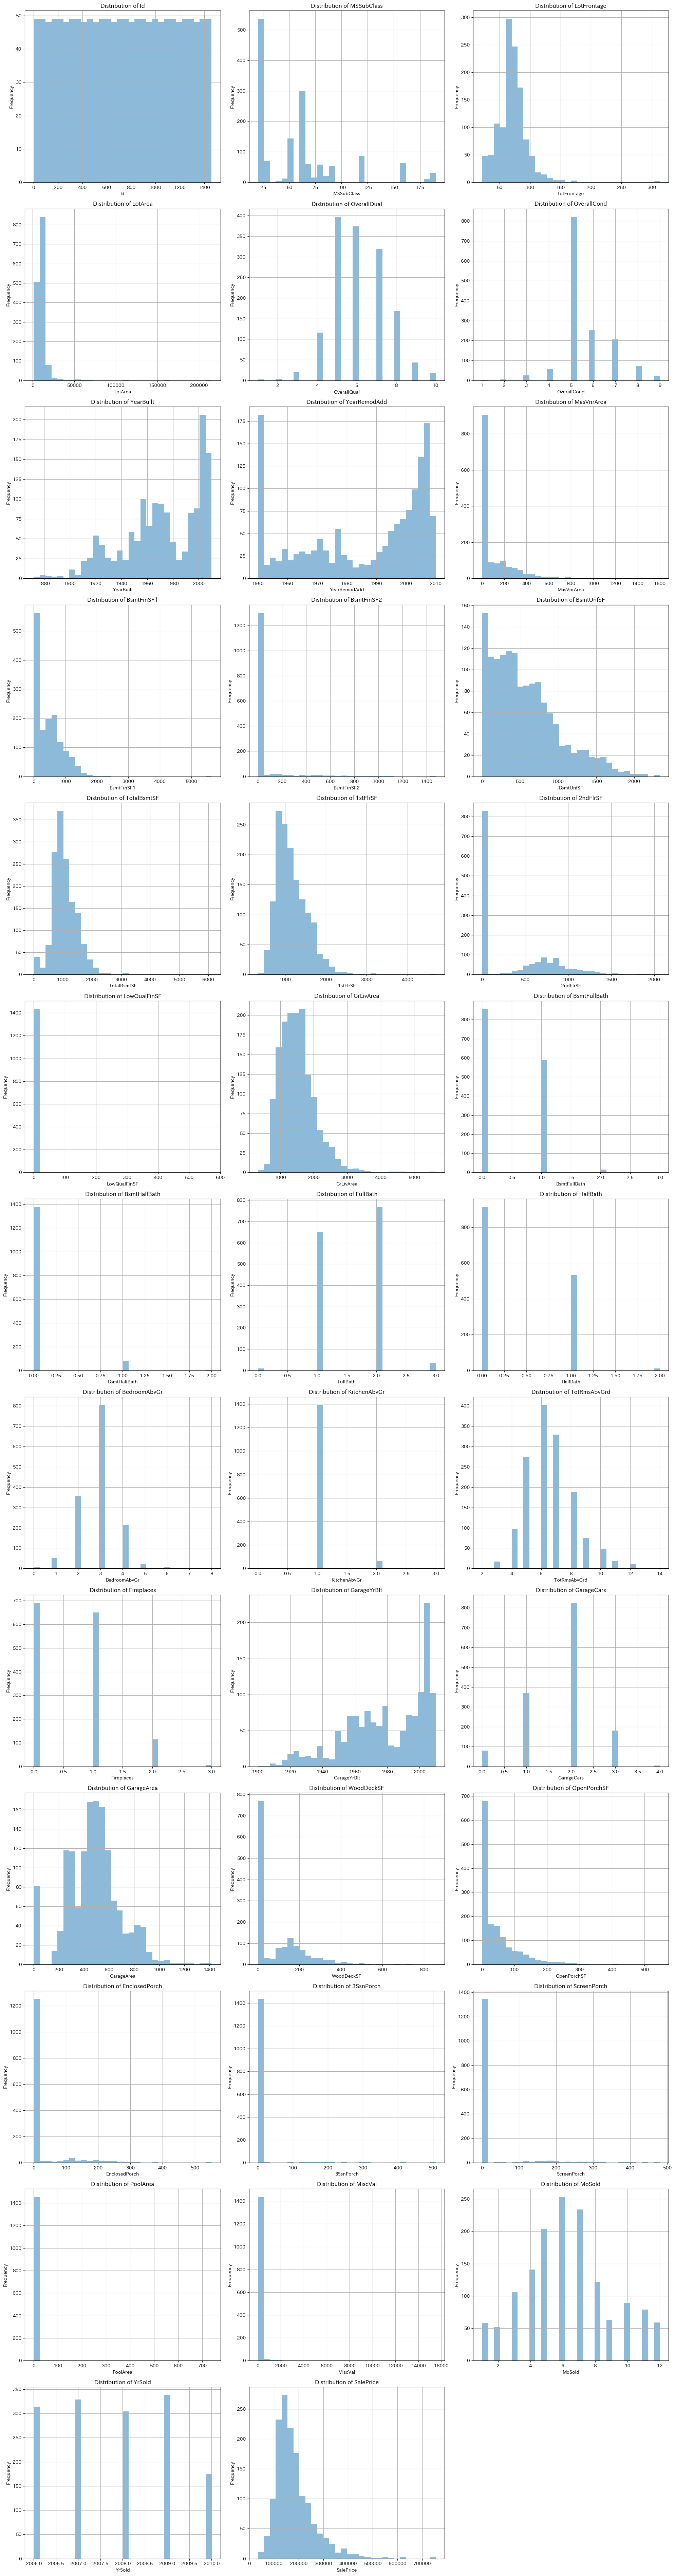

In [70]:
# 数値データのカラムを選択
numeric_features = df_train.select_dtypes(include=[np.number]).columns

# ヒストグラムをプロット
num_features = len(numeric_features)
plt.figure(figsize=(20, num_features * 2))  # グラフのサイズを調整

for i, feature in enumerate(numeric_features):
    plt.subplot(num_features // 3 + 1, 3, i + 1)
    df_train[feature].hist(bins=30, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()